# Funciones auxiliares

In [1]:
import numpy as np

### Máximo común divisor. Algoritmo de Euclides

In [2]:
def gcd(a, b):
    while b != 0:
        a, b = b, a%b
    return a

### Algoritmo extendido de Euclides

In [3]:
def extended_euclides(a: int, b: int):
    x0, x1, y0, y1 = 0, 1, 1, 0
    while a != 0:
        (q, a), b = divmod(b, a), a
        y0, y1 = y1, y0 - q * y1
        x0, x1 = x1, x0 - q * x1
    return x0, y0, b 

### Inverso modular

In [4]:
def mod_inverse(n, p):
    s, t, r = extended_euclides(n, p)
    return s % p

### Coprimo aleatorio

In [5]:
def find_coprime(n):
    for j in range(n//2+2, n):
        if gcd(j, n) == 1:
            yield j

### Logaritmo discreto (baby-step giant-step)

In [6]:
def discrete_logarithm(alpha, beta, p): # alpha ^ x = beta (mod p)
    m = int(np.ceil(p**0.5))

    table = {0: 1}
    for j in range(1, m):
        table[j] = (table[j-1]*alpha) % p

    alpha_m = pow(alpha, -m, p)
    y = beta

    for i in range(m):
        j = next(filter(lambda tup: tup[1] == y, zip(table.keys(), table.values())), (None, None))[0]
        if j is not None:
            return i*m+j
        else:
            y = y*alpha_m % p

    return None

# Cifrado ElGamal

- Se basa en la intratabilidad del problema del logaritmo discreto. Dado $p \in \mathbb{N}$ y dados $a, b\in \{1, ..., p-1\}$ encontrar $x$ tal que

$$
    a^x \equiv b\ (mod\ p)
$$

en el caso de que exista.

- Es fácil computacionalmente la exponenciación modular o el cálculo de inversos (algoritmo Euclides) pero no el logaritmo discreto.

- Se utilizará esto para generar una clave privada y pública para encriptar y desencriptar códigos, basado en la idea de que, teniendo la pública, solo se pueda conocer la privada si la has construido tú o resuelves el logaritmo discreto.

### Generación de clave pública y privada

- Se toma un número primo $p$ lo suficientemente grande.
- Se escogen dos números $g, a \in \{1, ..., p\}$. El primero se denominará _generador_ y el segundo _clave privada_.
- Se calcula

$$
    K := g^a\ (mod\ p)
$$
- La terna $(g, p, K)$ será la _clave pública_ y el par $(a, p)$ la clave privada. La clave pública será la que daremos a los que quieran enviarnos mensajes. Si alguien quisiera recuperar la clave privada debería resolver el logaritmo discreto.

In [7]:
class ElGamal:

    def __init__(self, p, g = None, a = None):

        if g is None:
            g = np.random.randint(1, p)
        
        if a is None:
            a = np.random.randint(1, p)

        self.p = p
        self.g = g
        self.a = a

        self.K = pow(g, a, p)


    def public_key(self):
        return (self.g, self.p, self.K)

    def private_key(self):
        return (self.a, self.p)

In [8]:
mis_claves = ElGamal(9349)

In [9]:
mis_claves.public_key()

(4335, 9349, 1787)

In [10]:
mis_claves.private_key()

(8775, 9349)

### Encriptación con clave pública

Trabajaremos con números (todo caracter tendrá una expresión numérica, siendo este proceso inversible). Para que alguien te envíe un mensaje encriptado que solo tú puedas conocer deberá realizar el siguiente procedimiento.

- Supongamos que el caracter que queremos enviar viene representado por el número $m$. Sin pérdida de generalidad $m<p$.
- Tomar un número $b \in \{1, ..., p\}$.
- Realizar la operación
$$
    y_1 := g^b\ (mod\ p)
$$
y la operación
$$
    y_2 := K^bm\ (mod\ p)
$$
- Enviamos el par $(y_1, y_2)$

In [11]:
def cifrate_num(m, key, b = None):
    g, p, K = key
    if b is None:
        b = np.random.randint(2, p)
    
    y_1 = pow(g, b, p)
    
    return (pow(g, b, p), pow(K, b, p)*m % p)

In [12]:
m25 = cifrate_num(25, mis_claves.public_key())
m145 = cifrate_num(145, mis_claves.public_key())
m236 = cifrate_num(236, mis_claves.public_key())

m25, m145, m236

((4423, 2120), (5953, 404), (416, 2845))

### Desencriptar con clave privada

Recibido el par $(y_1, y_2)$ el proceso de desencriptar será el siguiente.

$$
    y_1^{-a} y_2 = g^{-ab} K^bm =  g^{-ab} g^{ab}m = m \ (mod\ p)
$$

O, por el teorema de Fermat:

$$
    y_1^{-a} = y_1^{p-1-a}\ (mod\ p)
$$
pues $y_1^{p-1} \equiv 1\ (mod\ p)$ y entonces

$$
    y_1^{-a} y_2 = y_1^{p-1-a} K^bm =  g^{-(p-1-a)b} g^{ab}m = g^{p-1}m = m \ (mod\ p)
$$

Entonces bastaría realizar el cálculo $y_1^{-a} y_2$ para obtener $m$.

In [13]:
def uncifrate_num(y_tuple, key):
    a, p = key
    y1, y2 = y_tuple

    return pow(y1, p-1-a, p)*y2 % p

In [39]:
uncifrate_num(m25, mis_claves.private_key()), \
uncifrate_num(m145, mis_claves.private_key()), \
uncifrate_num(m236, mis_claves.private_key()) 

(25, 145, 236)

### Cifrar y descifrar texto

In [15]:
def cifrate_text_ElGamal(text, key):
    return list(map(lambda char: cifrate_num(ord(char), key), text))

def uncifrate_tuples_ElGamal(list_tuples, key):
    return "".join(map(lambda tup: chr(uncifrate_num(tup, key)), list_tuples))

In [16]:
tuples = cifrate_text_ElGamal("Hola buenos días", mis_claves.public_key())
tuples

[(8011, 2366),
 (2997, 8780),
 (1787, 885),
 (7104, 187),
 (8011, 8323),
 (234, 2303),
 (1, 117),
 (1787, 7320),
 (5780, 2585),
 (8312, 652),
 (8255, 288),
 (3335, 752),
 (8198, 3107),
 (5328, 237),
 (1, 97),
 (4698, 609)]

In [17]:
uncifrate_tuples_ElGamal(tuples, mis_claves.private_key() )

'Hola buenos días'

### Sacando clave privada a partir de la pública

In [18]:
g, p, K = mis_claves.public_key()
a, p = mis_claves.private_key()

supuesto_a = discrete_logarithm(g, K, p)
supuesto_a, a

(54, 8775)

In [19]:
pow(g, supuesto_a, p), pow(g, a, p)

(1787, 1787)


Para el siguiente problema no es asumible calcular el logaritmo discreto. Tomamos $p=337960305558063973$.

In [20]:
mis_claves2 = ElGamal(337960305558063973)
g, p, K = mis_claves2.public_key()
a, p = mis_claves2.private_key()

(g,p, K),(a, p)

((130661838813969996, 337960305558063973, 85208959287721155),
 (153476645216719003, 337960305558063973))

In [21]:
#supuesto_a = discrete_logarithm(g, K, p)
#supuesto_a, a

# Cifrado RSA

- Es el cifrado más utilizado.
- Es simétrico (lo encriptado con la pública se desencripta con la privada, y viceversa).
- Se fundamenta en la intratabilidad del problema de factorizar en números primos.

### Generación de clave pública y privada

- Se toman dos números primos $p, q \in \mathbb{N}$.
- Se considera $n := pq$.
- Se toma un número $e\in\{2, ..., n-1\}$ coprimo con $\varphi(n)$. La clave pública será $(n, e)$.
- Se calcula $d$ tal que

$$
    de = 1\ (mod\ \varphi(n))
$$

La clave privada será $(n, d)$.

- Al tener alguien la clave pública, no podrá obtener $d$ a menos que consiga $\varphi(n)$. Este cálculo fuerza a tener que factorizar $n$.

In [22]:
class RSA:
    def __init__(self, p, q):
        self.p = p
        self.q = q

        self.n = p*q

        phi_n = (p-1)*(q-1)

        self.e = int(np.random.choice(list(find_coprime(phi_n))))
        self.d = mod_inverse(self.e,phi_n)

    def public_key(self):
        return (self.n, self.e)

    def private_key(self):
        return (self.n, self.d)

In [23]:
my_rsa = RSA(61, 53)

my_rsa.public_key(), my_rsa.private_key()

((3233, 3071), (3233, 191))

### Encriptación con clave pública

Dado un número $m$ que representa el caracter a encriptar y la clave pública $(n, e)$ se calcula

$$
    M := m^e\ (mod\ n)
$$

In [24]:
def cifrate_num(number, key):
    n, e = key
    return pow(number, e, n)

In [25]:
m89 = cifrate_num(89, my_rsa.public_key())
m89

1924

### Desencriptar con clave privada

Se hace lo mismo pero considerando la clave privada $(n, d)$. Supongamos que $M$ es el mensaje encriptado, entonces

$$
    M^d = (m^e)^d = m^{ed} = m\ (mod\ n)
$$

pues por el pequeño teorema de Fermat $a^x = a\ (mod\ n)$ si $x = 1\ (mod\ \varphi(n))$ (condición que ocurre por construcción).

In [26]:
cifrate_num(m89, my_rsa.private_key())

89

### Encriptando y desencriptando texto

In [27]:
def cifrate_text(text, key):
    return "".join(map(lambda char: chr(cifrate_num(ord(char), key)), text))

In [28]:
txt_cifred = cifrate_text("El 0 es número natural", my_rsa.public_key())
txt_cifred

'\u088cŻҜ۷Ҝ\u0b50ৣҜਰ੫\u0b7e\u0b50ɪHҜਰ\u0bda\u0bfbুɪ\u0bdaŻ'

In [29]:
cifrate_text(txt_cifred, my_rsa.private_key())

'El 0 es número natural'

# El Algoritmo de Shor

Es un algoritmo para la factorización de números. Consta de una parte que corre en un ordenador clásico y otra parte que corre en un ordenador cuántico. Como interés meramente teórico y por el contenido algebraico que tiene, lo presentamos adaptando la parte cuántica a un algoritmo normal y corriente.

Dado un número natural $n\in\mathbb{N}$, no primo (se puede comprobar que no es primo en un tiempo asumible).

1. Se toma un número aleatorio $a<n$.
2. Se computa $f_0 = mcd(a, n)$.
    * Si $f_0 \neq 1$ entonces $f_0$ divide a $n$ y hemos terminado.
    * En caso contrario ir al paso 3.
3. _Parte cuántica_. Se busca el mínimo $r>0$ tal que
    $$
        a^r = 1\ (mod\ n)
    $$

    Esta parte se denomina estimación del periodo (de la función $f(x) = a^x\ (mod\ n)$), y es equivalente a calcular un logaritmo discreto (problema intratable computacionalmente). Sin embargo, en computación cuántica esta parte puede realizarse en un tiempo asumible. Nosotros utilizaremos el logaritmo discreto, pues encontrar $r$ equivale a resolver la ecuación
    $$
        a^{r-1} = a^{-1}\ (mod\ n)
    $$
    luego $r-1 = log_a (a^{-1}) \implies r = 1+log_a (a^{-1})$.
    
    * Si $r$ es par y $a^{r/2}\neq -1\ (mod\ n)$
    $$
        a^r-1 = 0 \ (mod\ n)
    $$
    
    se puede factorizar de la forma
 
    $$
        (a^{r/2}-1) (a^{r/2}+1) = 0\ (mod\ n)
    $$
    
    y entonces $n$ divide a $(a^{r/2}-1) (a^{r/2}+1)$.
    
    Denotemos $h^- = (a^{r/2}-1)$ y $h^+ = (a^{r/2}+1)$. Probaremos que $mcd(h^-, n)\neq 1$ y $mcd(h^+, n) \neq 1$
    
    Se tiene que $n|h^- h^+$ y entonces existe $k$ tal que
    
    $$
        kn = h^- h^+
    $$
    
    Si $mcd(h^+, n) = 1$ entonces existe $s_1, s_2$ tales que
    
    $$ s_1 h^+ + s_2 n = 1$$
    
    Multiplicando por $h^-$ queda 
    
    $$
        s_1 h^- h^+ + s_2 n h^- = h^- 
    $$
    
    luego
    
    $$
        s_1 kn + s_2 n h^+ = h^- 
    $$
    
    y entonces $n|h^{-}$, es decir,  $n|(a^{r/2}-1)$. Esto implicaría que $$ a^{r/2} = 1\ (mod\ n)$$ pero no es posible pues
    $r$ es el mínimo natural que cumple esa ecuación.
    
    Para probar que $mcd(h^-, n) \neq 1$ por reducción al absurdo se llegaría a que $ a^{r/2} = -1\ (mod\ n)$, pero hemos impuesto lo contrario.
    
    Como $f_1 = mcd(h^-, n)\neq 1$ y $f_2 = mcd(h^+, n) \neq 1$ entonces son factores no triviales de $n$
    
    * Si no se cumple alguna de las condiciones se vuelve al paso 1.
    

In [30]:
def find_period(a, p):
    a_ = mod_inverse(a, p)
    return discrete_logarithm(a, a_, p)+1

In [31]:
def shor(n):
    while True:
        a = int(np.random.choice(range(2, n-1)))
        f0 = gcd(a, n)
        if f0 != 1:
            return (f0, n//f0)
        else:
            r = find_period(a, n)
            if r % 2 == 0 and pow(a, r//2, n) != n-1:
                x = pow(a, r//2)
                f1 = gcd(x+1, n)
                f2 = gcd(x-1, n)
                return (f1, f2)

In [32]:
shor(3*11*23)

(253, 3)

In [33]:
shor(61*53)

(53, 61)

In [34]:
shor(797*557)

(557, 797)

## Complejidad de algoritmos
### Shor adaptado a un ordenador clásico

In [35]:
import matplotlib.pyplot as plt
from datetime import datetime

numeros = [3*11, 61*53, 61*557, 797*557, 797*2971, 2971*1361, 1361*8719]
numeros

[33, 3233, 33977, 443929, 2367887, 4043531, 11866559]

In [36]:
times = []
for number in numeros:
    
    time1 = datetime.now()
    a, b = shor(number)
    time2 = datetime.now()
    
    time = 1000000*((time2-time1).seconds) + ((time2-time1).microseconds)
    times.append(time)
    print("Número {:>10} : {:>12} microsegundos".format(number, time))

Número         33 :           95 microsegundos
Número       3233 :          414 microsegundos
Número      33977 :         6376 microsegundos
Número     443929 :       276325 microsegundos
Número    2367887 :       455393 microsegundos
Número    4043531 :       734131 microsegundos
Número   11866559 :     21337831 microsegundos


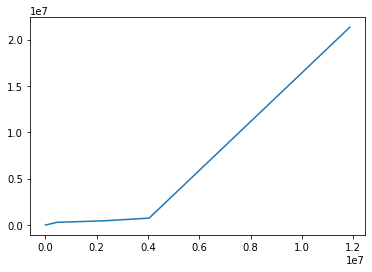

In [37]:
plt.plot(numeros, times)

In [38]:
[t/n for n, t in zip(np.diff(numeros), np.diff(times))]

[0.0996875,
 0.1939240176945095,
 0.6584892865506206,
 0.0930727178036111,
 0.1663467896522173,
 2.6337244350908624]